# Feature map visualization in PyTorch
## Imports, set device, load pre-trained ResNet50

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models.feature_extraction import create_feature_extractor

In [2]:
from pathlib import Path
from pprint import pprint
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns

DEVICE = 'cpu'  # cpu, cuda, mps

# Import ResNet50 pretranind one ImageNet (object recognition, 1000 classes)
# https://pytorch.org/vision/main/models.html
model = models.resnet50(weights="IMAGENET1K_V2").to(DEVICE)


In [3]:
# model

## Load example images

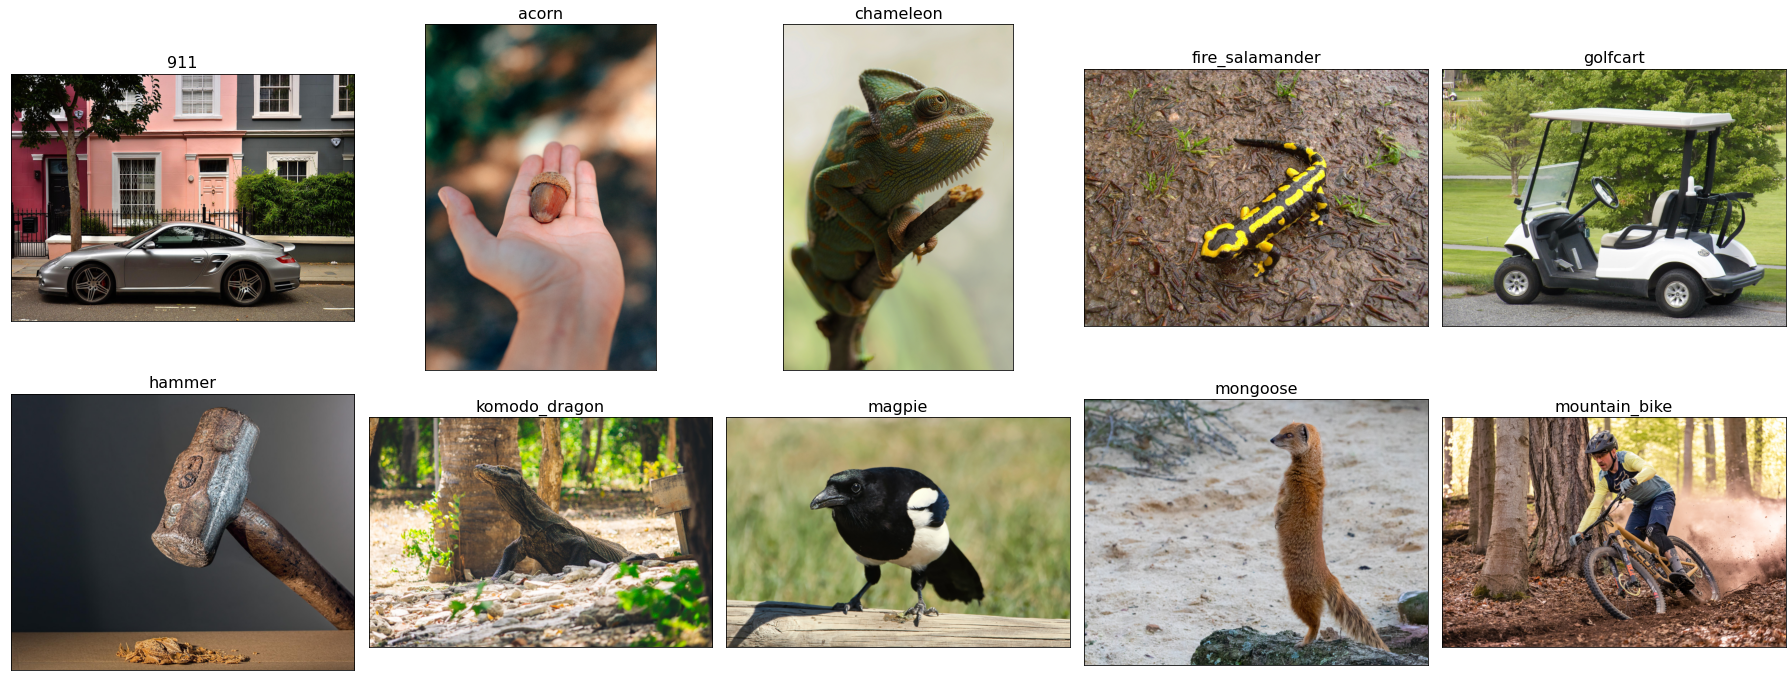

In [4]:
# Get example images
# Images are from unsplash.com, pexels.com, or pixabay.com and free to use
image_paths = sorted([x for x in Path('data/feature-maps').glob("*.jpg")])
images = {k.stem:v for k, v in zip(image_paths, image_paths)}
images.keys()

# Show example images with helper function
from img_utils import show_images
show_images(list(images.values()), titles=list(images.keys()), per_row=5, imsize=(5, 5), crop=False, resize=500);

## Transform image as PyTorch tensors and test inference

In [5]:
# Choose example image
IMAGE = 'chameleon'

def prepare_tensor_image(image_path:str, transform):
    """Prepares single image for Pytorch feed-forward.
    """
    img = Image.open(image_path)  # open image
    img = transform(img)  #  apply transformations
    img = torch.unsqueeze(img, 0).to(DEVICE)  # set batch size 1 and send to device
    return img

# Transformations
transform_prep = [  # normalizes and transform to tensor
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
]
transform_ops = [  
    # Image operations the ResNet50 is trained with 
    # https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html#torchvision.models.ResNet50_Weights
    transforms.Resize(256),
    transforms.CenterCrop(224),
]
transform = transforms.Compose(transform_prep + transform_ops)

test_img = prepare_tensor_image(images[IMAGE], transform)
model.eval()  # disable dropout, batchnorm, backpropagation ... for inference
with torch.no_grad():  # disable backpropagation
    outputs = model(test_img)  # run inference
    
# Get ImageNet categories
cats = pd.read_csv('https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt', header=None)    

# Get probability for each class
prob = torch.nn.functional.softmax(outputs[0], dim=0)
# Get top 5 probabilities for choosen image
topk = 5
print(f'Top {topk} probalilities for image "{IMAGE}": \n')
probs, classes = torch.topk(prob, topk)
for i in range(topk):
    probability = probs[i].item()
    class_label = cats[0][int(classes[i])]
    print(f'{int(probability*100)} {class_label}')

Top 5 probalilities for image "chameleon": 

27 African chameleon
0 green lizard
0 common iguana
0 agama
0 frilled lizard


## Get node names for feature maps

In [6]:
from torchvision.models.feature_extraction import get_graph_node_names

train_nodes, eval_nodes = get_graph_node_names(model)
assert([t == e for t, e in zip(train_nodes, eval_nodes)])

train_nodes

['x',
 'conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1.0.conv1',
 'layer1.0.bn1',
 'layer1.0.relu',
 'layer1.0.conv2',
 'layer1.0.bn2',
 'layer1.0.relu_1',
 'layer1.0.conv3',
 'layer1.0.bn3',
 'layer1.0.downsample.0',
 'layer1.0.downsample.1',
 'layer1.0.add',
 'layer1.0.relu_2',
 'layer1.1.conv1',
 'layer1.1.bn1',
 'layer1.1.relu',
 'layer1.1.conv2',
 'layer1.1.bn2',
 'layer1.1.relu_1',
 'layer1.1.conv3',
 'layer1.1.bn3',
 'layer1.1.add',
 'layer1.1.relu_2',
 'layer1.2.conv1',
 'layer1.2.bn1',
 'layer1.2.relu',
 'layer1.2.conv2',
 'layer1.2.bn2',
 'layer1.2.relu_1',
 'layer1.2.conv3',
 'layer1.2.bn3',
 'layer1.2.add',
 'layer1.2.relu_2',
 'layer2.0.conv1',
 'layer2.0.bn1',
 'layer2.0.relu',
 'layer2.0.conv2',
 'layer2.0.bn2',
 'layer2.0.relu_1',
 'layer2.0.conv3',
 'layer2.0.bn3',
 'layer2.0.downsample.0',
 'layer2.0.downsample.1',
 'layer2.0.add',
 'layer2.0.relu_2',
 'layer2.1.conv1',
 'layer2.1.bn1',
 'layer2.1.relu',
 'layer2.1.conv2',
 'layer2.1.bn2',
 'layer2.1.relu_1',
 'layer2.

## Extract and display feature maps on inference

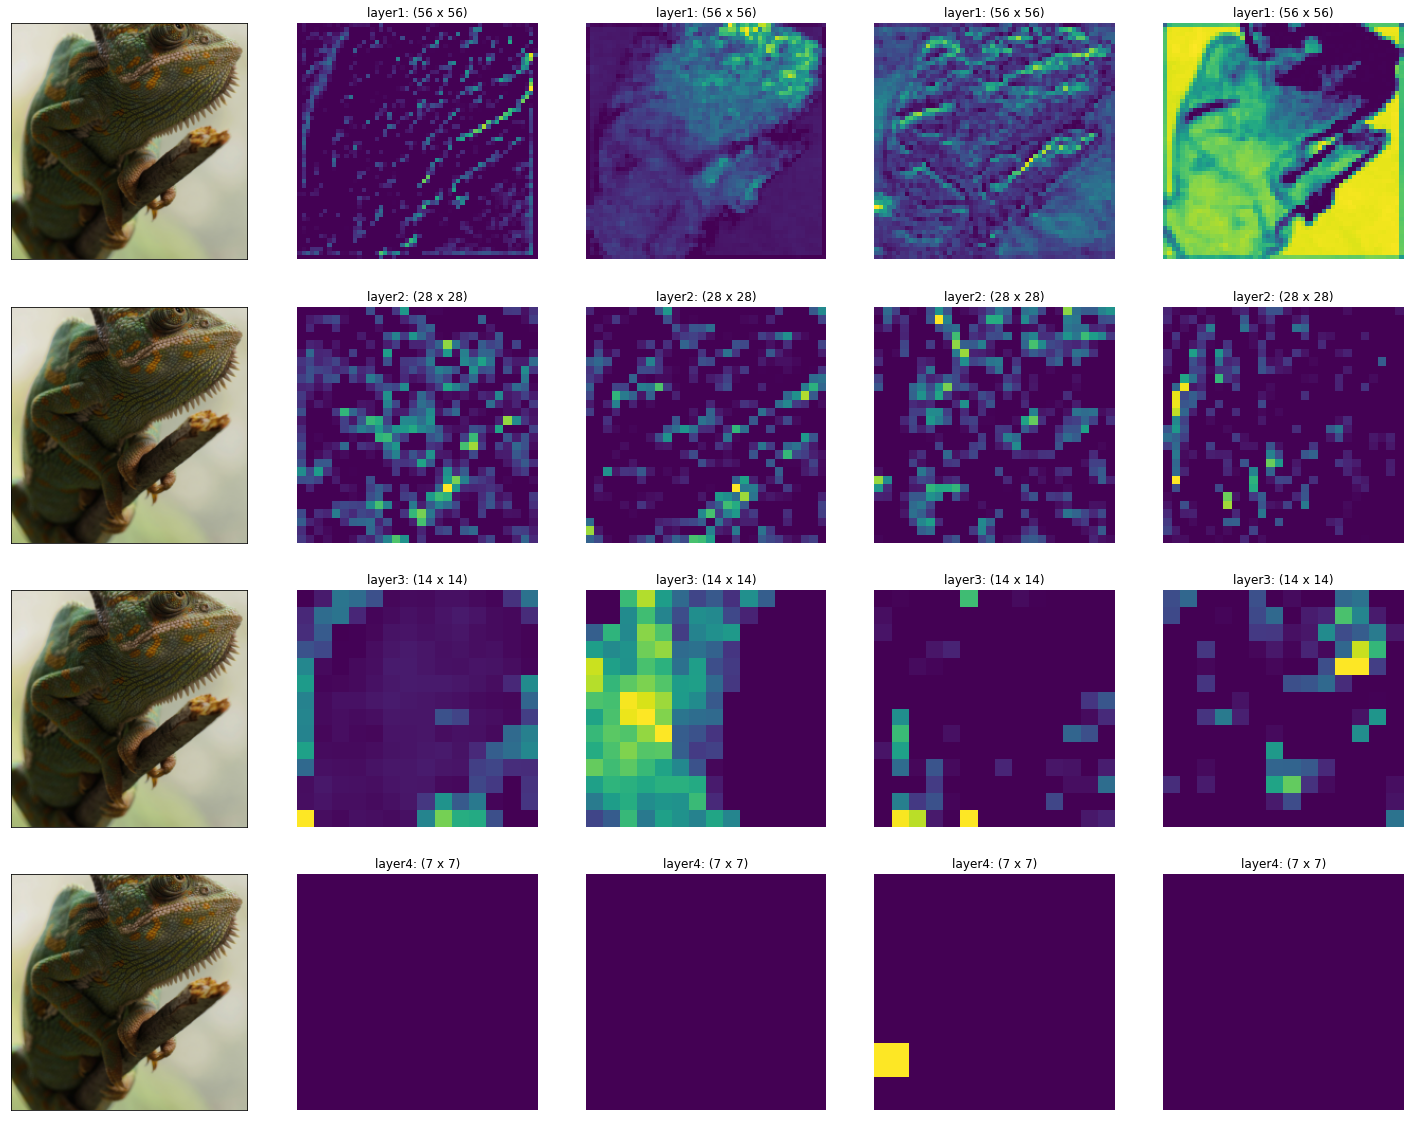

In [7]:
IMAGE = 'chameleon'  # choose image
# Choose nodes; if not fully specified, the last layer of a given class is used (e.g., layer4 == layer4.2.relu_2)
return_nodes = ['layer1', 'layer2', 'layer3', 'layer4']

feature_extractor = create_feature_extractor(model.to(DEVICE), return_nodes=return_nodes)
model.eval()
with torch.no_grad():
    test_img = prepare_tensor_image(images[IMAGE], transform)
    outputs = feature_extractor(test_img.to(DEVICE))

show_transform = transforms.Compose(transform_ops)  # only apply relevant image operations shown input
show_img = Image.open(images[IMAGE])
show_img = show_transform(show_img)

# Display 4 random feature maps from selectted layers
fig, ax = plt.subplots(len(return_nodes), 5, figsize=(25, len(return_nodes)*5))
for i, layer in enumerate(return_nodes):
    feat_maps = outputs[layer].cpu().numpy().squeeze(0)
    feat_maps = random.sample(list(feat_maps), 4)
    ax[i][0].imshow(show_img)
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    for j, feat_map in enumerate(feat_maps):
        sns.heatmap(feat_map, ax=ax[i][j+1], cbar=False, cmap="viridis")
        ax[i][j+1].set_xticks([])
        ax[i][j+1].set_yticks([])
        ax[i][j+1].set_title(f'{layer}: ({feat_map.shape[0]} x {feat_map.shape[1]})')

# Visualize model with torchviz

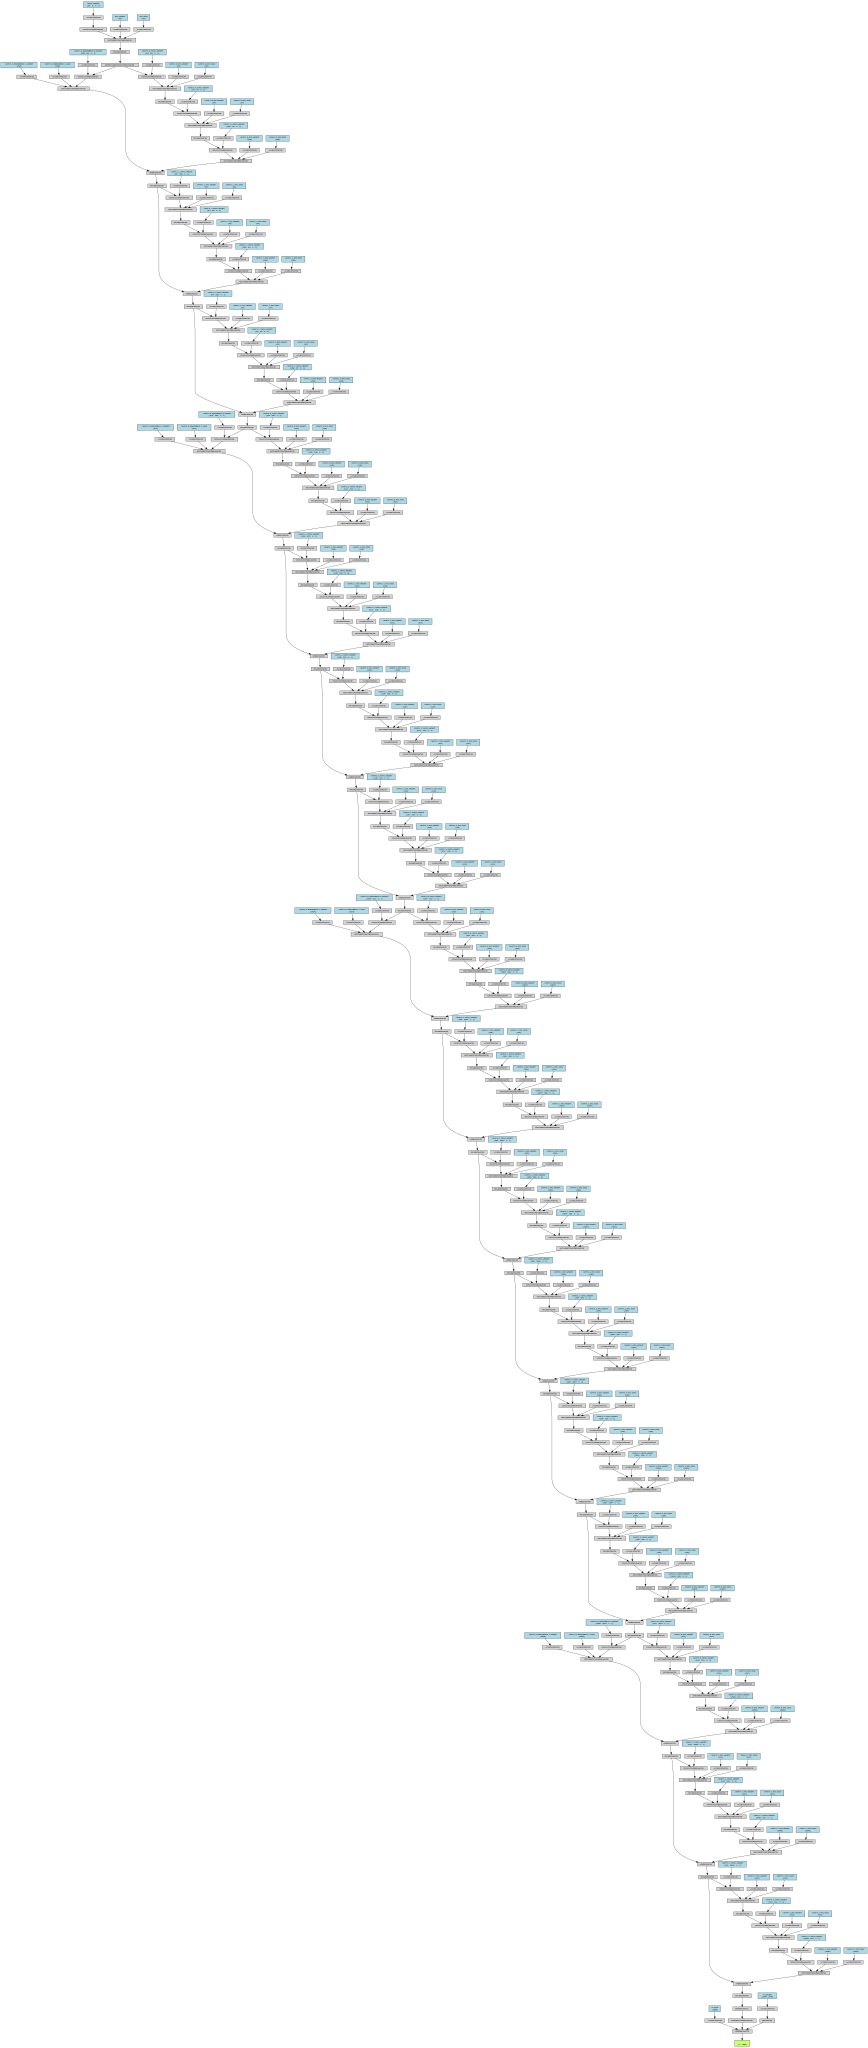

In [8]:
# Install graphviz first https://github.com/szagoruyko/pytorchviz
from torchviz import make_dot

x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)
out = model(x)
make_dot(out, params=dict(list(model.named_parameters())))